In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
    datasets,
)
import pickle
import tensorflow.keras.backend as K
import tensorboard as tb
from model_continuous import GAN
import librosa as lb
from preprocess import load_raw_audio
from preprocess import denormalise
from IPython.lib.display import Audio
import IPython
import pandas as pd

In [19]:
DIM = 64
CHANNELS = 1 #keeping as 1? what for mono or stereo?
PHASE_PARAM = 2
LATENT_DIM = 100
DISCRIMINATOR_STEPS = 5
GP_WEIGHT = 10
LEARNING_RATE = 1e-4
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
BATCH_SIZE = 64
EPOCHS = 5000
CHECKPOINT_FREQ = 1000

model_directory ="C:/Users/Jayde/Desktop/wavegan/models_3011.1350"

In [20]:

gan = GAN(
    latent_dim = LATENT_DIM,
    discriminator_steps= DISCRIMINATOR_STEPS,
    gp_weight= GP_WEIGHT,
    n_categories= 10,
    n_cont= 2
)

In [37]:
generator = gan.generator
generator.load_weights(f"{model_directory}/generator400")

In [38]:
def create_cat_inputs(latent_dim, n_cat, n_con, size_per_cat, con_type = "zero"):
    z_dim = latent_dim-n_cat-n_con
    size = size_per_cat*n_cat
    z= tf.random.normal(shape=(size, z_dim))
    
    con = tf.zeros(shape=(size, n_con)) if con_type == "zero" else tf.random.normal(shape=(size, n_con))
    cat = np.zeros(shape=(size, n_cat))
    idxs = []
    for i in range(n_cat):
        idx = [i]*size_per_cat
        idxs += idx
    cat[np.arange(size),idxs] = 1
    cat = tf.convert_to_tensor(cat, dtype=tf.float32)
    inputs = tf.concat([z,con, cat], axis=1)
    inputs = tf.split(inputs, n_cat, axis=0)
    return inputs

In [39]:
inputs = create_cat_inputs(LATENT_DIM,n_cat=10,n_con=2,size_per_cat=10, con_type = "zero")
outputs=[]
for input in inputs:
    generated_audio = generator.predict(input) 
    generated_audio= np.squeeze(generated_audio)
    #print(generated_audio.shape)
    audio = denormalise(generated_audio,f"{model_directory}/normaliser_values")
    outputs.append(audio)


1/1 [==============================] - 1s 707ms/step
DENORMALISING- MEAN:-0.00021153796114958823, STD_DEV:0.08716892451047897
DENORMALISED
1/1 [==============================] - 1s 749ms/step
DENORMALISING- MEAN:-0.00021153796114958823, STD_DEV:0.08716892451047897
DENORMALISED
1/1 [==============================] - 1s 715ms/step
DENORMALISING- MEAN:-0.00021153796114958823, STD_DEV:0.08716892451047897
DENORMALISED
1/1 [==============================] - 1s 656ms/step
DENORMALISING- MEAN:-0.00021153796114958823, STD_DEV:0.08716892451047897
DENORMALISED
1/1 [==============================] - 1s 634ms/step
DENORMALISING- MEAN:-0.00021153796114958823, STD_DEV:0.08716892451047897
DENORMALISED
1/1 [==============================] - 1s 630ms/step
DENORMALISING- MEAN:-0.00021153796114958823, STD_DEV:0.08716892451047897
DENORMALISED
1/1 [==============================] - 1s 644ms/step
DENORMALISING- MEAN:-0.00021153796114958823, STD_DEV:0.08716892451047897
DENORMALISED
1/1 [======================

In [42]:
code_1 = outputs[6]
sr = 16000
for audio in code_1:
    IPython.display.display(Audio(audio, rate =sr))

Text(108.22222222222221, 0.5, 'Amplitude')

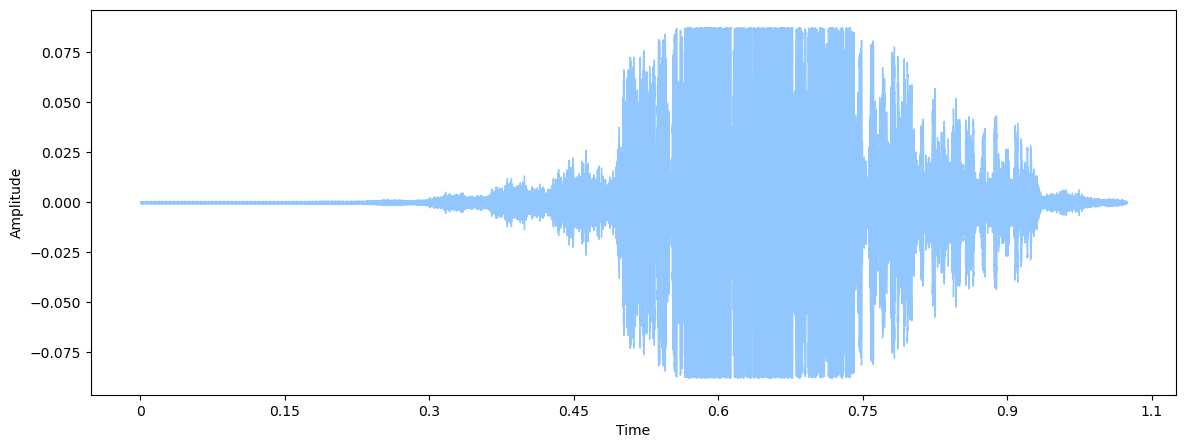

In [41]:
import librosa.display

plt.figure(figsize=(14, 5))
#plotting the sampled signal
librosa.display.waveshow(code_1[2], sr=sr)
plt.ylabel("Amplitude")

In [53]:
from scipy.io.wavfile import write
write("example_audio4.wav", sr, audio_1)

In [14]:
%tensorboard

UsageError: Line magic function `%tensorboard` not found.


In [27]:
event_file = os.listdir(f"{model_directory}/logs/train")[0]
event_file = f"{model_directory}/logs/train/{event_file}"

In [28]:
from tensorflow.python.summary.summary_iterator import summary_iterator
import struct
g_loss=[]
d_loss =[]
d_gp=[]
d_w_loss=[]
q_loss =[]
steps=[]
for e in summary_iterator(event_file):    
    for v in e.summary.value:
        if v.tag == 'epoch_g_loss':            
            g_loss.append(struct.unpack('f', v.tensor.tensor_content)[0])
        
        elif v.tag == 'epoch_d_loss':            
            d_loss.append(struct.unpack('f', v.tensor.tensor_content)[0])
        
        elif v.tag == 'epoch_d_gp':            
            d_gp.append(struct.unpack('f', v.tensor.tensor_content)[0])

        elif v.tag == 'epoch_d_wass_loss':            
            d_w_loss.append(struct.unpack('f', v.tensor.tensor_content)[0])

        elif v.tag == 'epoch_q_loss':            
            q_loss.append(struct.unpack('f', v.tensor.tensor_content)[0])

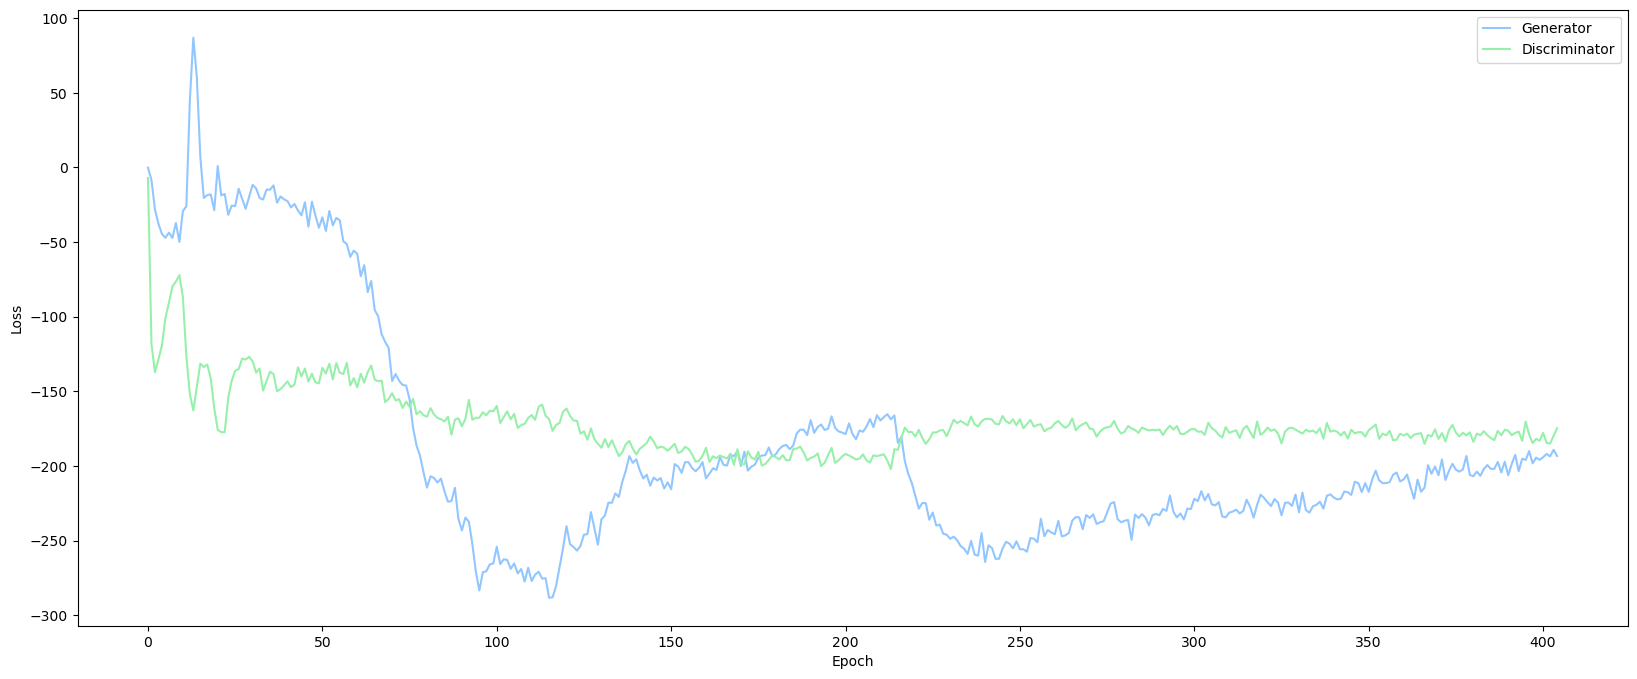

In [30]:
plt.style.use('seaborn-pastel')
plt.figure(figsize=(20,8))
plt.plot(g_loss, label = "Generator")
plt.plot(d_loss, label = "Discriminator")
plt.legend()
#plt.xlim(0,5000)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()